In [4]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input
from keras import applications


import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
TARGET_X = 64
TARGET_Y = 64
BATCH_SIZE = 64
CLASS_NUM = 3
EPOCH = 10

In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('/Users/gustavonrm/Desktop/VCOM/FEUP-VCOM2/multiclass_v2.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].str.split(' ')
train_classes["id"]=train_classes["id"].apply(append_ext)


print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1000fe2e667721fe.png          [51]
1  10041eb49b297c08.png          [51]
2  100501c227f8beea.png          [13]
3  1008abd71f3ed5bc.png           [1]
4  100a0dcde728cb36.png          [51]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

Found 17670 validated image filenames belonging to 3 classes.
Found 4417 validated image filenames belonging to 3 classes.


In [5]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [6]:
# warm up model
# first: train only the top layers (which were randomly initialized)
model = create_model(input_shape=(TARGET_X, TARGET_Y, 3), n_out=CLASS_NUM)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True
    
optimizer = optimizers.Adam(lr=0.0001)
metrics = ["accuracy", "categorical_accuracy"]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callbacks = [es]
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metrics)
model.summary()

AttributeError: module 'keras.applications' has no attribute 'ResNet50'

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

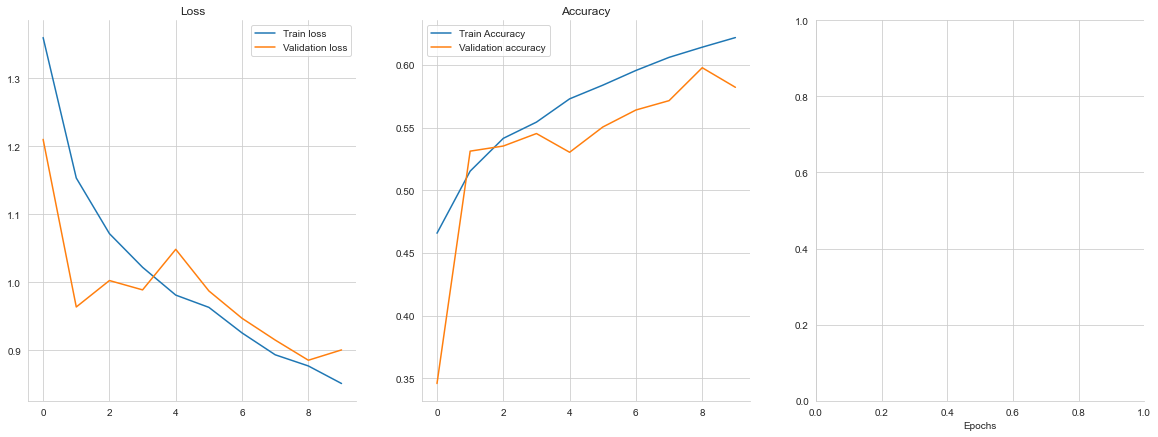

In [15]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()